In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download("stopwords")
from pymorphy2 import MorphAnalyzer
from collections import Counter 
from sklearn.feature_extraction.text import *
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import * 
morph = MorphAnalyzer()

from string import punctuation
from nltk.corpus import stopwords
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/laidhimonthegreen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import numpy as np

In [3]:
# загружаем файлы
train = pd.read_csv("./balanced_dataset/train.csv", sep = "\t")
test = pd.read_csv("./balanced_dataset/test.csv", sep = "\t")

In [4]:
train.head()

,Unnamed: 0,index,notes,id,note_id,TAG,EMO_PRED,EPISODE_PRED,WORK_PRED,NAR_PRED,PRED,TAG_TWO,words
0,9759,2265,В комнате с утра совсем холодно. Ирка плохо се...,134,296119,NAR,0.295,0.290,0.082,0.334,NAR,NAR,"['комнате', 'утра', 'холодно', 'ирка', 'плохо'..."
1,7724,226,**Пятница.** Ночью порядочно подморозило. Вчер...,1639,178485,NAR,0.130,0.169,0.123,0.578,NAR,NAR,"['пятница', 'ночью', 'порядочно', 'подморозило..."
2,4788,1594,"Сегодня седьмой день, как я на «отдыхе», и все...",690,317424,EPISODE,0.212,0.311,0.206,0.272,EPISODE,EPISODE,"['сегодня', 'седьмой', 'день', 'отдыхе', 'идет..."
3,6334,1546,Суббота Фоминой недели \nНаписал о. Вениами...,577,64703,WORK,0.192,0.224,0.383,0.201,WORK,WORK,"['суббота', 'фоминой', 'недели', 'написал', 'в..."
4,5237,621,"Получил письмо от Ратушняка (4.6), просит дать...",206,372661,WORK,0.076,0.146,0.674,0.104,WORK,WORK,"['получил', 'письмо', 'ратушняка', '4.6', 'про..."


### Стилистические фичи

In [5]:
from nltk import sent_tokenize, word_tokenize

In [6]:
def normalize(text):    
    """ токенизируем текст и убираем стоп-слова """
    words = text.lower().split()
    words = [word.strip(punct) for word in words]
    words = [word for word in words if word] 

    return words

In [7]:
def get_syllables(word):
    counter = 0
    for sym in word:
        if sym in "аеёиоуыэюя":
            counter += 1
    return counter

In [8]:
train["words"] = train.notes.apply(lambda x: normalize (x))
test["words"] = test.notes.apply(lambda x: normalize (x))

In [9]:
train["syllables_mean"] = train.words.apply(lambda x: np.mean([get_syllables(w) for w in x]))
test["syllables_mean"] = test.words.apply(lambda x: np.mean([get_syllables(w) for w in x]))

In [10]:
train["sentences"] = train.notes.apply(lambda x: sent_tokenize (x))
test["sentences"] = test.notes.apply(lambda x: sent_tokenize (x))

In [11]:
train["split_sentences"] = train.sentences.apply(lambda x: [normalize (s) for s in x])
test["split_sentences"] = test.sentences.apply(lambda x: [normalize (s) for s in x])

In [12]:
train["sentences_count"] = train.sentences.apply(lambda x: len (x))
test["sentences_count"] = test.sentences.apply(lambda x: len (x))

In [13]:
train["sentences_mean"] = train.split_sentences.apply(lambda x: np.mean([len (s) for s in x]))
test["sentences_mean"] = test.split_sentences.apply(lambda x: np.mean([len (s) for s in x]))

In [14]:
train["sentences_median"] = train.split_sentences.apply(lambda x: np.median([len (s) for s in x]))
test["sentences_median"] = test.split_sentences.apply(lambda x: np.median([len (s) for s in x]))

In [15]:
train["sentences_median"] = train.split_sentences.apply(lambda x: np.median([len (s) for s in x]))
test["sentences_median"] = test.split_sentences.apply(lambda x: np.median([len (s) for s in x]))

In [16]:
train.head()

,Unnamed: 0,index,notes,id,note_id,TAG,EMO_PRED,EPISODE_PRED,WORK_PRED,NAR_PRED,PRED,TAG_TWO,words,syllables_mean,sentences,split_sentences,sentences_count,sentences_mean,sentences_median
0,9759,2265,В комнате с утра совсем холодно. Ирка плохо се...,134,296119,NAR,0.295,0.290,0.082,0.334,NAR,NAR,"[в, комнате, с, утра, совсем, холодно, ирка, п...",2.474227,"[В комнате с утра совсем холодно., Ирка плохо ...","[[в, комнате, с, утра, совсем, холодно], [ирка...",10,9.700000,7.5
1,7724,226,**Пятница.** Ночью порядочно подморозило. Вчер...,1639,178485,NAR,0.130,0.169,0.123,0.578,NAR,NAR,"[пятница, ночью, порядочно, подморозило, вчера...",2.323529,"[**Пятница., ** Ночью порядочно подморозило., ...","[[пятница], [ночью, порядочно, подморозило], [...",13,7.846154,6.0
2,4788,1594,"Сегодня седьмой день, как я на «отдыхе», и все...",690,317424,EPISODE,0.212,0.311,0.206,0.272,EPISODE,EPISODE,"[сегодня, седьмой, день, как, я, на, отдыхе, и...",2.306667,"[Сегодня седьмой день, как я на «отдыхе», и вс...","[[сегодня, седьмой, день, как, я, на, отдыхе, ...",4,18.750000,18.5
3,6334,1546,Суббота Фоминой недели \nНаписал о. Вениами...,577,64703,WORK,0.192,0.224,0.383,0.201,WORK,WORK,"[суббота, фоминой, недели, написал, о, вениами...",2.530726,[Суббота Фоминой недели \nНаписал о. Вениам...,"[[суббота, фоминой, недели, написал, о, вениам...",6,29.833333,21.0
4,5237,621,"Получил письмо от Ратушняка (4.6), просит дать...",206,372661,WORK,0.076,0.146,0.674,0.104,WORK,WORK,"[получил, письмо, от, ратушняка, 4.6, просит, ...",2.650943,"[Получил письмо от Ратушняка (4.6), просит дат...","[[получил, письмо, от, ратушняка, 4.6, просит,...",9,11.777778,11.0


In [17]:
train.groupby("TAG").mean()

,Unnamed: 0,index,id,note_id,EMO_PRED,EPISODE_PRED,WORK_PRED,NAR_PRED,syllables_mean,sentences_count,sentences_mean,sentences_median
TAG,,,,,,,,,,,,
EMO,1914.981941,1174.799097,665.191874,206038.677201,0.448032,0.206553,0.106729,0.238675,2.210470,12.726862,11.785580,10.046275
EPISODE,4068.613839,1278.232143,714.136161,213016.997768,0.212263,0.370815,0.143949,0.272969,2.250870,12.488839,12.027506,10.465402
NAR,7563.614035,1094.162281,719.370614,192305.793860,0.186428,0.234967,0.153250,0.425406,2.164815,14.561404,9.377103,8.005482
WORK,5934.916854,1283.537079,660.240449,227626.480899,0.125079,0.190787,0.461769,0.222371,2.438803,10.561798,12.685481,11.040449


In [18]:
train["fk"] = - train["syllables_mean"].apply(lambda x: 60.1 * x)  - train["sentences_mean"].apply(lambda x: 1.3 * x)
test["fk"] = - test["syllables_mean"].apply(lambda x: 60.1 * x)  - test["sentences_mean"].apply(lambda x: 1.3 * x)
train["fk"] = train["fk"].apply(lambda x: 206.835 + x)
test["fk"] = test["fk"].apply(lambda x: 206.835 + x)

In [19]:
train.groupby("TAG").mean()

,Unnamed: 0,index,id,note_id,EMO_PRED,EPISODE_PRED,WORK_PRED,NAR_PRED,syllables_mean,sentences_count,sentences_mean,sentences_median,fk
TAG,,,,,,,,,,,,,
EMO,1914.981941,1174.799097,665.191874,206038.677201,0.448032,0.206553,0.106729,0.238675,2.210470,12.726862,11.785580,10.046275,58.664524
EPISODE,4068.613839,1278.232143,714.136161,213016.997768,0.212263,0.370815,0.143949,0.272969,2.250870,12.488839,12.027506,10.465402,55.921938
NAR,7563.614035,1094.162281,719.370614,192305.793860,0.186428,0.234967,0.153250,0.425406,2.164815,14.561404,9.377103,8.005482,64.539411
WORK,5934.916854,1283.537079,660.240449,227626.480899,0.125079,0.190787,0.461769,0.222371,2.438803,10.561798,12.685481,11.040449,43.771799


In [20]:
def get_styl_feats(dataset):
    feats = []
    for i, number in enumerate(dataset["syllables_mean"]):
        feats.append(np.array([dataset.iloc[i].syllables_mean, dataset.iloc[i].sentences_median, 
                               dataset.iloc[i].sentences_median, dataset.iloc[i].fk]))
    dataset["feats"] = feats
    return dataset

In [21]:
train = get_styl_feats(train)
test = get_styl_feats(test)

train_feats = [np.array(x) for x in list(train.feats)]
test_feats = [np.array(x) for x in list(test.feats)]

In [22]:
clf_feat = LogisticRegression(solver="newton-cg")

In [23]:
clf_feat.fit(train_feats, train.TAG)

/home/laidhimonthegreen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

         EMO       0.48      0.20      0.28       117
     EPISODE       0.38      0.15      0.22       112
         NAR       0.40      0.68      0.50       104
        WORK       0.49      0.75      0.59       115

    accuracy                           0.44       448
   macro avg       0.44      0.44      0.40       448
weighted avg       0.44      0.44      0.40       448



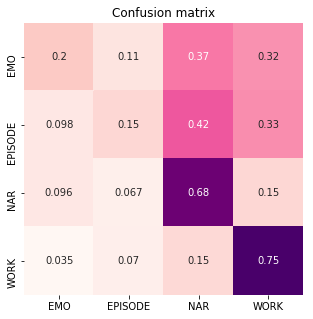

In [24]:
feats_preds = clf_feat.predict(test_feats)
print(classification_report(test.TAG, feats_preds)) 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

m = confusion_matrix(test.TAG, feats_preds)
m = m.astype('float') / m.sum(axis=1)[:, np.newaxis]

labels = clf_feat.classes_
plt.figure(figsize = (5,5))
sns.heatmap(data=m, annot=True, cbar=False, xticklabels=labels, yticklabels=labels, cmap="RdPu")
plt.title("Confusion matrix")
plt.show()

### Добавим новые фичи - пунктуацию 

In [25]:
train["dash_count"] = train["notes"].apply(lambda x: Counter(x)["—"])/train["sentences_count"]
train["comma_count"] = train["notes"].apply(lambda x: Counter(x)[","])/train["sentences_count"]
train["exclamation_count"] = train["notes"].apply(lambda x: Counter(x)["!"])/train["sentences_count"]
train["question_count"] = train["notes"].apply(lambda x: Counter(x)["?"])/train["sentences_count"]
train["dot_count"] = train["notes"].apply(lambda x: Counter(x)["."])/train["sentences_count"]
train["right_parenth_count"] = train["notes"].apply(lambda x: Counter(x)[")"])/train["sentences_count"]
train["left_parenth_count"] = train["notes"].apply(lambda x: Counter(x)["("])/train["sentences_count"]
train["parenth_diff"] = train["right_parenth_count"]-train["left_parenth_count"]/train["sentences_count"]
train["gradus_count"] = train["notes"].apply(lambda x: Counter(x)["°"])/train["sentences_count"]
train["n_count"] = train["notes"].apply(lambda x: Counter(x)["\n"])/train["sentences_count"]

train["[_count"] = train["notes"].apply(lambda x: Counter(x)["["])/train["sentences_count"]  

In [26]:
test["dash_count"] = test["notes"].apply(lambda x: Counter(x)["—"])/test["sentences_count"]
test["comma_count"] = test["notes"].apply(lambda x: Counter(x)[","])/test["sentences_count"]
test["exclamation_count"] = test["notes"].apply(lambda x: Counter(x)["!"])/test["sentences_count"]
test["question_count"] = test["notes"].apply(lambda x: Counter(x)["?"])/test["sentences_count"]
test["dot_count"] = test["notes"].apply(lambda x: Counter(x)["."])/test["sentences_count"]
test["right_parenth_count"] = test["notes"].apply(lambda x: Counter(x)[")"])/test["sentences_count"]
test["left_parenth_count"] = test["notes"].apply(lambda x: Counter(x)["("])/test["sentences_count"]
test["parenth_diff"] = test["right_parenth_count"]-test["left_parenth_count"]/test["sentences_count"]
test["gradus_count"] = test["notes"].apply(lambda x: Counter(x)["°"])/test["sentences_count"]
test["n_count"] = test["notes"].apply(lambda x: Counter(x)["\n"])/test["sentences_count"]

test["[_count"] = test["notes"].apply(lambda x: Counter(x)["["])/test["sentences_count"] 

In [27]:
train.groupby("TAG").mean()

,Unnamed: 0,index,id,note_id,EMO_PRED,EPISODE_PRED,WORK_PRED,NAR_PRED,syllables_mean,sentences_count,...,comma_count,exclamation_count,question_count,dot_count,right_parenth_count,left_parenth_count,parenth_diff,gradus_count,n_count,[_count
TAG,,,,,,,,,,,,,,,,,,,,,
EMO,1914.981941,1174.799097,665.191874,206038.677201,0.448032,0.206553,0.106729,0.238675,2.210470,12.726862,...,1.401268,0.061562,0.058971,1.116622,0.068036,0.064737,0.060793,0.000141,0.192207,0.029798
EPISODE,4068.613839,1278.232143,714.136161,213016.997768,0.212263,0.370815,0.143949,0.272969,2.250870,12.488839,...,1.337603,0.056509,0.027608,1.096849,0.054844,0.054810,0.047427,0.001217,0.176297,0.018013
NAR,7563.614035,1094.162281,719.370614,192305.793860,0.186428,0.234967,0.153250,0.425406,2.164815,14.561404,...,0.866781,0.024080,0.010714,1.116203,0.058238,0.054489,0.052866,0.006883,0.119130,0.038716
WORK,5934.916854,1283.537079,660.240449,227626.480899,0.125079,0.190787,0.461769,0.222371,2.438803,10.561798,...,0.958659,0.009256,0.003331,1.203891,0.161086,0.088679,0.148960,0.005299,0.240094,0.113356


In [28]:
def get_punct_and_styl_feats(dataset):
    feats = []
    for i, number in enumerate(dataset["syllables_mean"]):
        feats.append(np.array([dataset.iloc[i].syllables_mean, dataset.iloc[i].sentences_median, 
                               dataset.iloc[i].sentences_median, dataset.iloc[i].fk,
                               dataset.iloc[i].comma_count, dataset.iloc[i].dot_count, 
                               dataset.iloc[i].parenth_diff, 
                               dataset.iloc[i].gradus_count, dataset.iloc[i].question_count, 
                               dataset.iloc[i].exclamation_count,dataset.iloc[i].dash_count,
                               dataset.iloc[i].n_count, dataset.iloc[i][r"[_count"]]))
    dataset["with_punct_feats"] = feats
    return dataset

In [29]:
train = get_punct_and_styl_feats(train)
test = get_punct_and_styl_feats(test)

train_feats = [np.array(x) for x in list(train.with_punct_feats)]
test_feats = [np.array(x) for x in list(test.with_punct_feats)]

In [30]:
clf_feat.fit(train_feats, train.TAG)

/home/laidhimonthegreen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

         EMO       0.48      0.37      0.42       117
     EPISODE       0.34      0.23      0.28       112
         NAR       0.47      0.63      0.54       104
        WORK       0.64      0.80      0.71       115

    accuracy                           0.51       448
   macro avg       0.49      0.51      0.49       448
weighted avg       0.49      0.51      0.49       448



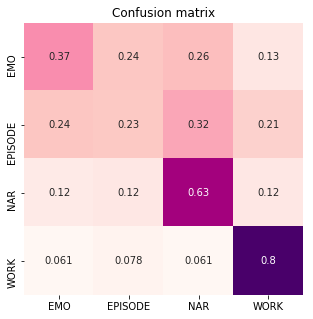

In [31]:
feats_preds = clf_feat.predict(test_feats)
print(classification_report(test.TAG, feats_preds)) 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

m = confusion_matrix(test.TAG, feats_preds)
m = m.astype('float') / m.sum(axis=1)[:, np.newaxis]

labels = clf_feat.classes_
plt.figure(figsize = (5,5))
sns.heatmap(data=m, annot=True, cbar=False, xticklabels=labels, yticklabels=labels, cmap="RdPu")
plt.title("Confusion matrix")
plt.show()

### Добавим новые фичи -- POS-теги

In [32]:
def get_pos_tag(word):
    tag = morph.parse(word)[0].tag.POS
    return (tag)

In [33]:
train["pos_tags"] = train["words"].apply(lambda x: [str(get_pos_tag(lex)) for lex in x])
test["pos_tags"] = test["words"].apply(lambda x: [str(get_pos_tag(lex)) for lex in x])

In [35]:
train["noun_count"] = train["pos_tags"].apply(lambda x: Counter(x)["NOUN"]/len(x))
train["verb_count"] = train["pos_tags"].apply(lambda x: Counter(x)["VERB"]/len(x))
train["adjf_count"] = train["pos_tags"].apply(lambda x: Counter(x)["ADJF"]/len(x))
train["adjs_count"] = train["pos_tags"].apply(lambda x: Counter(x)["ADJS"]/len(x))
train["comp_count"] = train["pos_tags"].apply(lambda x: Counter(x)["COMP"]/len(x))
train["prtf_count"] = train["pos_tags"].apply(lambda x: Counter(x)["PRTF"]/len(x))
train["prcl_count"] = train["pos_tags"].apply(lambda x: Counter(x)["PRCL"]/len(x)) 

train["intj_count"] = train["pos_tags"].apply(lambda x: Counter(x)["INTJ"]/len(x))
train["num_count"] = train["pos_tags"].apply(lambda x: Counter(x)["NUMR"]/len(x))
train["conj_count"] = train["pos_tags"].apply(lambda x: Counter(x)["CONJ"]/len(x))
train["advb_count"] = train["pos_tags"].apply(lambda x: Counter(x)["ADVB"]/len(x)) 

In [36]:
test["noun_count"] = test["pos_tags"].apply(lambda x: Counter(x)["NOUN"]/len(x))
test["verb_count"] = test["pos_tags"].apply(lambda x: Counter(x)["VERB"]/len(x))
test["adjf_count"] = test["pos_tags"].apply(lambda x: Counter(x)["ADJF"]/len(x))
test["adjs_count"] = test["pos_tags"].apply(lambda x: Counter(x)["ADJS"]/len(x))
test["comp_count"] = test["pos_tags"].apply(lambda x: Counter(x)["COMP"]/len(x))
test["prtf_count"] = test["pos_tags"].apply(lambda x: Counter(x)["PRTF"]/len(x))
test["prcl_count"] = train["pos_tags"].apply(lambda x: Counter(x)["PRCL"]/len(x)) 

test["intj_count"] = test["pos_tags"].apply(lambda x: Counter(x)["INTJ"]/len(x))
test["num_count"] = test["pos_tags"].apply(lambda x: Counter(x)["NUMR"]/len(x))
test["conj_count"] = test["pos_tags"].apply(lambda x: Counter(x)["CONJ"]/len(x))
test["advb_count"] = test["pos_tags"].apply(lambda x: Counter(x)["ADVB"]/len(x)) 

In [37]:
train.groupby("TAG").mean()

,Unnamed: 0,index,id,note_id,EMO_PRED,EPISODE_PRED,WORK_PRED,NAR_PRED,syllables_mean,sentences_count,...,adj_count,prcl_count,intj_count,adjf_count,adjs_count,comp_count,prtf_count,num_count,conj_count,advb_count
TAG,,,,,,,,,,,,,,,,,,,,,
EMO,1914.981941,1174.799097,665.191874,206038.677201,0.448032,0.206553,0.106729,0.238675,2.210470,12.726862,...,0.122542,0.054703,0.002611,0.122542,0.013301,0.004547,0.006583,0.003355,0.106826,0.068067
EPISODE,4068.613839,1278.232143,714.136161,213016.997768,0.212263,0.370815,0.143949,0.272969,2.250870,12.488839,...,0.113668,0.034218,0.001932,0.113668,0.009654,0.003264,0.010956,0.005738,0.080613,0.064637
NAR,7563.614035,1094.162281,719.370614,192305.793860,0.186428,0.234967,0.153250,0.425406,2.164815,14.561404,...,0.098715,0.027696,0.001461,0.098715,0.009366,0.002912,0.006273,0.004478,0.073161,0.067055
WORK,5934.916854,1283.537079,660.240449,227626.480899,0.125079,0.190787,0.461769,0.222371,2.438803,10.561798,...,0.116506,0.015181,0.000766,0.116506,0.007486,0.001856,0.008705,0.004021,0.057855,0.031994


In [40]:
def get_punctstylpos_feats(dataset):
    feats = []
    for i, number in enumerate(dataset["syllables_mean"]):
        feats.append(np.array([dataset.iloc[i].syllables_mean, dataset.iloc[i].sentences_median, 
                               dataset.iloc[i].sentences_median, dataset.iloc[i].fk,
                               dataset.iloc[i].comma_count, dataset.iloc[i].dot_count, 
                               dataset.iloc[i].parenth_diff, 
                               dataset.iloc[i].gradus_count, dataset.iloc[i].question_count, 
                               dataset.iloc[i].exclamation_count,dataset.iloc[i].dash_count,
                               dataset.iloc[i].n_count, dataset.iloc[i][r"[_count"],
                               dataset.iloc[i].noun_count, dataset.iloc[i].verb_count, 
                               dataset.iloc[i].adjf_count,dataset.iloc[i].adjs_count,
                               dataset.iloc[i].comp_count, dataset.iloc[i].prtf_count,
                               dataset.iloc[i].prcl_count, dataset.iloc[i].intj_count, 
                               dataset.iloc[i].num_count,dataset.iloc[i].conj_count,
                               dataset.iloc[i].advb_count]))
    dataset["with_punct_pos_feats"] = feats
    return dataset

In [41]:
train = get_punctstylpos_feats(train)
test = get_punctstylpos_feats(test)

train_feats = [np.array(x) for x in list(train.with_punct_pos_feats)]
test_feats = [np.array(x) for x in list(test.with_punct_pos_feats)]

In [42]:
clf_feat.fit(train_feats, train.TAG)

/home/laidhimonthegreen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

         EMO       0.66      0.65      0.65       117
     EPISODE       0.50      0.27      0.35       112
         NAR       0.50      0.64      0.57       104
        WORK       0.70      0.84      0.76       115

    accuracy                           0.60       448
   macro avg       0.59      0.60      0.58       448
weighted avg       0.59      0.60      0.58       448



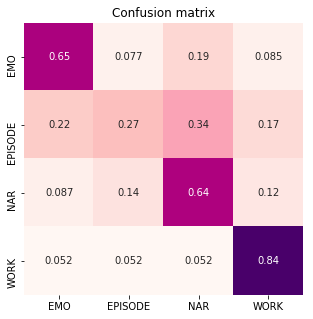

In [43]:
feats_preds = clf_feat.predict(test_feats)
print(classification_report(test.TAG, feats_preds)) 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

m = confusion_matrix(test.TAG, feats_preds)
m = m.astype('float') / m.sum(axis=1)[:, np.newaxis]

labels = clf_feat.classes_
plt.figure(figsize = (5,5))
sns.heatmap(data=m, annot=True, cbar=False, xticklabels=labels, yticklabels=labels, cmap="RdPu")
plt.title("Confusion matrix")
plt.show()